#  Trotterized Simulation of 2-Qubit Superconducting Qubits

This notebook simulates the quantum dynamics of a 2-qubit superconducting system under a simple Ising + transverse-field Hamiltonian using **second-order Trotter decomposition**.

---

## Goal of the Simulation

We model the time evolution of a 2-qubit system governed by the Hamiltonian:

\\[
H = J Z_0 Z_1 + h (X_0 + X_1)
\\]

Where:
- \\( J \\): strength of ZZ coupling between qubits (e.g., capacitive or inductive coupling)
- \\( h \\): strength of transverse microwave drive applied to each qubit

We simulate the dynamics by:
- Decomposing the total Hamiltonian into commuting and non-commuting parts
- Using second-order **Trotter-Suzuki decomposition** to approximate time evolution
- Tracking the expectation value \\( \langle Z_0 \rangle \\) as a function of time

---

## Hamiltonian Structure

The Hamiltonian consists of two parts:
- **Interaction term**: \\( H_Z = J Z_0 Z_1 \\)
- **Transverse field**: \\( H_X = h (X_0 + X_1) \\)

Because \( H_Z \) and \( H_X \) do **not commute**, the full time evolution operator cannot be implemented exactly in gate-based simulation. Instead, we approximate it using Trotter decomposition.

---

## Trotterized Time Evolution

To simulate \( U(t) = e^{-i H t} \), we use the second-order Trotter formula:

\\[
U(\delta t) \approx e^{-i H_X \delta t / 2} \cdot e^{-i H_Z \delta t} \cdot e^{-i H_X \delta t / 2} + \mathcal{O}(\delta t^3)
\\]

This is repeated for multiple small steps to evolve the system over time.

### Breakdown of One Trotter Step:

1. Apply RX rotation on each qubit: \
   \\( e^{-i h X \delta t / 2} \rightarrow \texttt{rx(-h delta t, q)} \\)

2. Apply ZZ interaction: \
   \\( e^{-i J Z Z \delta t} \rightarrow \texttt{CX → RZ → CX} \\) sandwich

3. Apply RX rotation again on each qubit

---

## Initial State

We initialize the system in the state:

\\[
|\psi(0)\rangle = |+\rangle \otimes |0\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle) \otimes |0\rangle
\\]

This state is chosen to allow nontrivial dynamics under both X and ZZ terms.

---

## Observable: Expectation Value of \\( Z_0 \\)

At each Trotter step, we compute:

\\[
\langle Z_0 \rangle = \langle \psi(t) | Z \otimes I | \psi(t) \rangle
\\]

This measures how qubit 0 behaves in the Z-basis as the system evolves — giving insight into both local behavior and entanglement.

---

## What the Code Does

- Defines a Trotter step using gates that implement the time-evolution operator
- Initializes the system in \\( |+\rangle \otimes |0\rangle \\)
- Repeats the Trotter step over 60 time steps
- Tracks and records \\( \langle Z_0 \rangle \\) at each step
- Plots \\( \langle Z_0 \rangle \\) as a function of time

---

## Final Output: Dynamics of ⟨Z₀⟩

The plot reveals how qubit 0’s state evolves due to:
- Coherent X-rotations (drive)
- Entangling ZZ interactions

The shape and frequency of oscillations reflect the interplay between drive strength `h`, interaction strength `J`, and the Trotter time step \\(\delta_t \\).

---

## Summary

This simulation demonstrates:
- Digital quantum simulation of analog Hamiltonians
- Gate-based implementation of second-order Trotter evolution
- Real-time tracking of quantum observables
- Physics of driven, interacting superconducting qubits

This is a foundational exercise for understanding quantum simulation, gate synthesis, and analog-digital correspondence in near-term quantum devices.



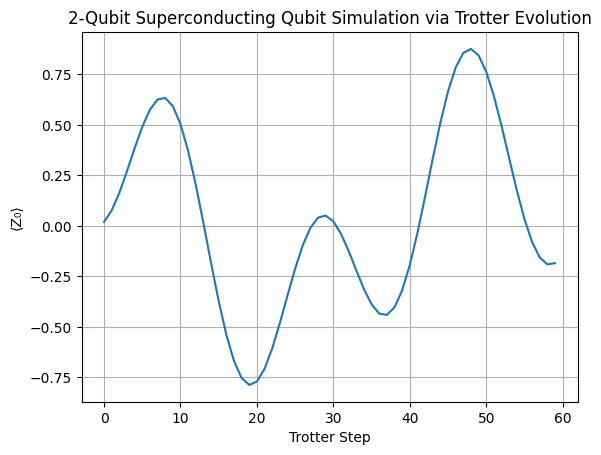

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Pauli
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------
# Purpose:
# This code simulates a 2-qubit superconducting qubit system evolving under a Hamiltonian:
# H = J Z0 Z1 + h (X0 + X1)
# using second-order Trotter decomposition.
# ----------------------------------------

# Parameters
J = 1.0         # ZZ interaction strength (e.g., capacitive coupling)
h = 1.0         # Transverse drive strength (e.g., resonant microwave drive)
delta_t = 0.1   # Time step for Trotter evolution
steps = 60      # Number of Trotter steps

# Observable: ⟨Z₀⟩
Z0 = Pauli("ZI")

# Function to apply a second-order Trotter step
def second_order_trotter_step(qc, J, h, delta_t):
    # Half-step transverse field: RX(-h Δt) on each qubit
    qc.rx(-h * delta_t, 0)
    qc.rx(-h * delta_t, 1)

    # ZZ interaction: exp(-i J Z₀Z₁ Δt) = CZ sandwich + RZ
    qc.cx(0, 1)
    qc.rz(-2 * J * delta_t, 1)
    qc.cx(0, 1)

    # Half-step transverse field again
    qc.rx(-h * delta_t, 0)
    qc.rx(-h * delta_t, 1)

# Initial state |+⟩ ⊗ |0⟩
psi = Statevector.from_label('+0')
z_expectations = []

# Trotter evolution loop
for step in range(steps):
    qc = QuantumCircuit(2)
    second_order_trotter_step(qc, J, h, delta_t)
    psi = psi.evolve(qc)
    z_exp = psi.expectation_value(Z0).real
    z_expectations.append(z_exp)

# Plot ⟨Z₀⟩ vs Trotter step
plt.plot(z_expectations)
plt.xlabel("Trotter Step")
plt.ylabel("⟨Z₀⟩")
plt.title("2-Qubit Superconducting Qubit Simulation via Trotter Evolution")
plt.grid(True)
plt.show()


## Fidelity Comparison: Trotter vs Exact Evolution

In this section, we compare second-order Trotterized evolution to exact time evolution for a 2-qubit system governed by:

\\[
H = J Z_0 Z_1 + h (X_0 + X_1)
\\]

- **Exact evolution** is computed by exponentiating the full Hamiltonian matrix: \\( e^{-i H \Delta t} \\)
- **Trotter evolution** uses gate-based second-order Trotter steps.

We track:
- \\( \langle Z_0 \rangle \\) over time (Trotter circuit)
- Fidelity between the exact and Trotter-evolved state at each step:

\\[
F(t) = |\langle \psi_{\text{exact}}(t) | \psi_{\text{trotter}}(t) \rangle|^2
\\]

This quantifies how well the Trotter approximation captures the true dynamics.


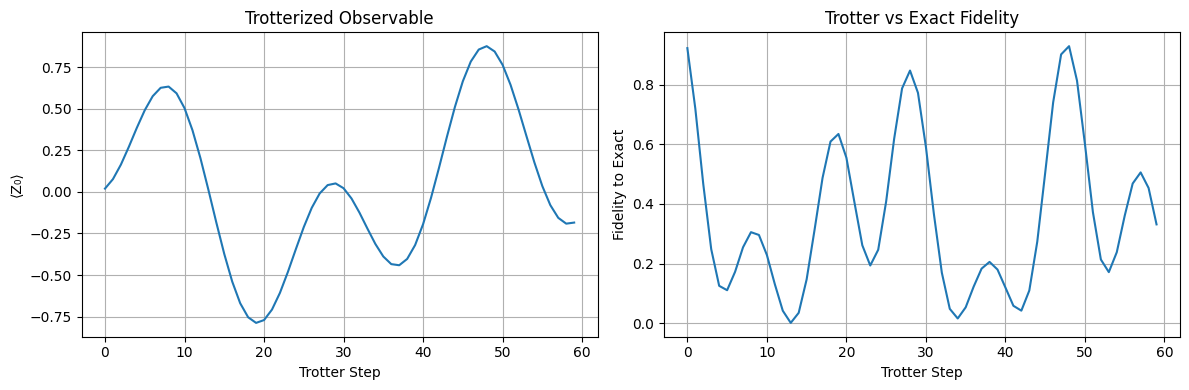

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Pauli, Operator
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

# -----------------------------
# Purpose:
# Compare second-order Trotterized evolution to exact evolution
# for a 2-qubit superconducting qubit system.
# -----------------------------

# Parameters
J = 1.0        # ZZ interaction strength
h = 1.0        # Transverse field strength
delta_t = 0.1  # Time step
steps = 60     # Number of evolution steps

# Pauli matrices
I = np.eye(2, dtype=complex)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)

# Kronecker helper
def kron(*args):
    result = args[0]
    for a in args[1:]:
        result = np.kron(result, a)
    return result

# Build full Hamiltonian matrix: H = J Z⊗Z + h (X⊗I + I⊗X)
H = J * kron(Z, Z) + h * (kron(X, I) + kron(I, X))
U_exact = expm(-1j * H * delta_t)  # Exact time evolution operator

# Observable: Z on qubit 0
Z0 = Pauli("ZI")

# Function to build one second-order Trotter step
def second_order_trotter_step(qc, J, h, delta_t):
    # Half-step transverse field: RX
    qc.rx(-h * delta_t, 0)
    qc.rx(-h * delta_t, 1)
    # ZZ interaction: implemented via CZ + RZ + CZ
    qc.cx(0, 1)
    qc.rz(-2 * J * delta_t, 1)
    qc.cx(0, 1)
    # Another half-step transverse field
    qc.rx(-h * delta_t, 0)
    qc.rx(-h * delta_t, 1)

# Initial state: |+⟩ ⊗ |0⟩
psi0 = Statevector.from_label('+0')
psi_exact = psi0.data.copy()
psi_trotter = psi0.copy()

fidelities = []
z_expectations = []

# Time evolution loop
for _ in range(steps):
    # --- Exact evolution ---
    psi_exact = U_exact @ psi_exact  # Matrix-vector multiplication

    # --- Trotter evolution ---
    qc = QuantumCircuit(2)
    second_order_trotter_step(qc, J, h, delta_t)
    psi_trotter = psi_trotter.evolve(qc)

    # Fidelity between exact and Trotter state
    F = np.abs(np.vdot(psi_exact, psi_trotter.data))**2
    fidelities.append(F)

    # Observable ⟨Z₀⟩ from Trotter state
    z_exp = psi_trotter.expectation_value(Z0).real
    z_expectations.append(z_exp)

# -----------------------------
# Plotting
# -----------------------------
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(z_expectations, label='⟨Z₀⟩ (Trotter)')
plt.xlabel("Trotter Step")
plt.ylabel("⟨Z₀⟩")
plt.title("Trotterized Observable")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(fidelities, label='Fidelity')
plt.xlabel("Trotter Step")
plt.ylabel("Fidelity to Exact")
plt.title("Trotter vs Exact Fidelity")
plt.grid(True)

plt.tight_layout()
plt.show()


# Trotterized Entanglement Entropy in Coupled Superconducting Qubits

## Physical Background

In superconducting qubit systems, qubits are often coupled via a `ZZ` interaction (e.g., capacitive or inductive coupling), and each qubit can be individually driven with transverse microwave fields. The system Hamiltonian studied here is:

\\[
H = J Z_0 Z_1 + h (X_0 + X_1)
\\]

- \\( J \\): Strength of the qubit-qubit interaction (e.g., via a coupling capacitor)
- \\( h \\): Strength of the transverse microwave drive
- \\( Z_0 Z_1 \\): Coupling term that entangles the qubits
- \\( X_0 + X_1 \\): Local rotations driving each qubit

This is similar to the **transverse-field Ising model**, which exhibits rich entanglement dynamics in both quantum simulation and quantum hardware.

---

## Time Evolution via Trotterization

To simulate real-time evolution under \\( H \\), we use the **second-order Trotter-Suzuki decomposition**. The exact unitary evolution operator over a time \\( \delta t \\) is:

\\[
U(\delta t) = e^{-i H \delta t}
\\]

But since \\( H = H_Z + H_X \\) and \\( [H_Z, H_X] \neq 0 \\), we approximate:

\\[
U(\delta t) \approx e^{-i H_X \delta t / 2} \cdot e^{-i H_Z \delta t} \cdot e^{-i H_X \delta t / 2}
\\]

where:

- \\( H_Z = J Z_0 Z_1 \\)
- \\( H_X = h (X_0 + X_1) \\)

This method reduces the Trotter error to order \\( O(\delta t^3) \\), making it more accurate than first-order Trotterization.

---

## Measuring Entanglement via von Neumann Entropy

To quantify **entanglement** between the two qubits, we compute the **von Neumann entropy** of the reduced density matrix:

1. From the full pure state \\( |\psi(t)\rangle \\), compute the **density matrix** \\( \rho = |\psi\rangle\langle\psi| \\)
2. Trace out one qubit (e.g., qubit 1) to get the reduced state:
   \\[
   \rho_0 = \text{Tr}_1(\rho)
   \\]
3. Compute the **entropy** of \\( \rho_0 \\):
   \\[
   S(\rho_0) = -\text{Tr}(\rho_0 \log_2 \rho_0)
   \\]

This entropy satisfies:
- \\( S = 0 \\): Product state (no entanglement)
- \\( S = 1 \\): Maximal entanglement for a 2-qubit pure state

The entropy grows over time as the interaction \\( J Z_0 Z_1 \\) entangles the qubits.

---

## Initial State

We initialize the system in a partially entangled state:

\\[
|\psi(0)\rangle = |+\rangle \otimes |0\rangle
\\]

where \\( |+\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle) \\), making it sensitive to both the transverse field and the coupling.

---

## Simulation Results

By simulating the system over several Trotter steps and computing the entropy at each step, we observe the **time-dependent growth of entanglement** due to the Hamiltonian dynamics. This provides insight into how interactions build quantum correlations in superconducting qubit systems and how such systems may be used for entanglement-based quantum protocols.

---

## References

- Suzuki, M. *General theory of higher-order decomposition of exponential operators*. Commun. Math. Phys. **1990**.
- Nielsen & Chuang, *Quantum Computation and Quantum Information*
- Kandala et al., *Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets*. Nature **2017**.


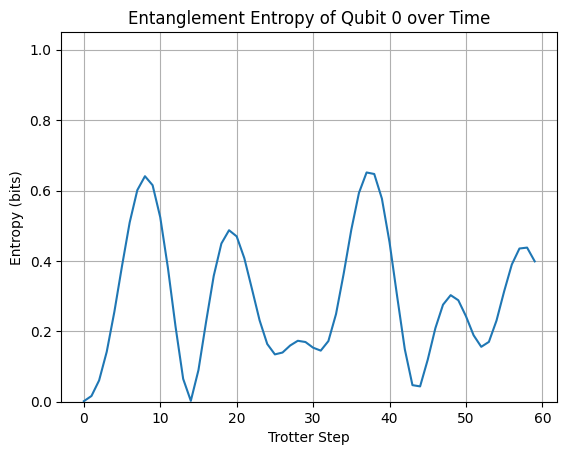

In [3]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, partial_trace, entropy
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Purpose:
# Simulate entanglement entropy growth in a 2-qubit superconducting qubit system.
# Hamiltonian: H = J Z0 Z1 + h (X0 + X1)
# Using second-order Trotterization.
# -----------------------------

# Parameters
J = 1.0         # Coupling strength
h = 1.0         # Transverse field
delta_t = 0.1   # Trotter step size
steps = 60      # Number of Trotter steps

# Function: Second-order Trotter step
def second_order_trotter_step(qc, J, h, delta_t):
    # Half-step transverse X rotations
    qc.rx(-h * delta_t, 0)
    qc.rx(-h * delta_t, 1)

    # ZZ interaction via RZ and CNOTs
    qc.cx(0, 1)
    qc.rz(-2 * J * delta_t, 1)
    qc.cx(0, 1)

    # Half-step transverse again
    qc.rx(-h * delta_t, 0)
    qc.rx(-h * delta_t, 1)

# Initial state: |+⟩ ⊗ |0⟩
psi = Statevector.from_label('+0')

# Lists to store results
entropies = []

# Evolution loop
for _ in range(steps):
    qc = QuantumCircuit(2)
    second_order_trotter_step(qc, J, h, delta_t)
    psi = psi.evolve(qc)

    # Compute reduced density matrix for qubit 0
    rho0 = partial_trace(psi, [1])
    
    # Compute von Neumann entropy of reduced state
    S = entropy(rho0, base=2)
    entropies.append(S)

# Plotting entropy vs Trotter step
plt.plot(entropies, label='Entanglement Entropy')
plt.xlabel("Trotter Step")
plt.ylabel("Entropy (bits)")
plt.title("Entanglement Entropy of Qubit 0 over Time")
plt.grid(True)
plt.ylim(0, 1.05)
plt.show()


# 3-Qubit Trotterized Simulation vs Exact Evolution

## Physical Model

We study a 3-qubit system governed by the **transverse-field Ising Hamiltonian** with nearest-neighbor coupling:

\\[
H = J (Z_0 Z_1 + Z_1 Z_2) + h (X_0 + X_1 + X_2)
\\]

- \\( J \\): Coupling strength between neighboring qubits (e.g., via ZZ interaction)
- \\( h \\): Transverse field strength (e.g., local microwave drive)
- This is a minimal model for many-body quantum dynamics and entanglement generation in superconducting qubit arrays.

---

## Simulation Method

We use **second-order Trotter-Suzuki decomposition** to approximate time evolution under this Hamiltonian. The Trotter step is:

\\[
U(\delta t) \approx e^{-i H_X \delta t/2} \, e^{-i H_Z \delta t} \, e^{-i H_X \delta t/2}
\\]

- \\( H_X = h(X_0 + X_1 + X_2) \\)
- \\( H_Z = J(Z_0 Z_1 + Z_1 Z_2) \\)

The system evolves step-by-step from the initial state \(|\psi_0\rangle = |+0+\rangle\), which is sensitive to both the coupling and drive terms.

---

## Fidelity Benchmarking

We compare the **Trotterized evolution** to the **exact evolution** using the full 8×8 matrix exponential:

\\[
U_{\text{exact}} = e^{-i H \delta t}
\\]

At each step, we compute the **fidelity**:

\\[
F = \left| \langle \psi_{\text{exact}} | \psi_{\text{trotter}} \rangle \right|^2
\\]

and track the observable \( \langle Z_1 \rangle \) from the Trotter state.

---

## Output

- **⟨Z₁⟩ vs Trotter step**: Captures dynamics of the middle qubit
- **Fidelity vs Trotter step**: Quantifies Trotter error over time

This benchmark demonstrates how well Trotterized simulation can approximate real-time quantum evolution in small superconducting qubit chains.

---

## References

- Suzuki, M. *General theory of higher-order decomposition of exponential operators*. CMP (1990)
- Nielsen & Chuang, *Quantum Computation and Quantum Information*


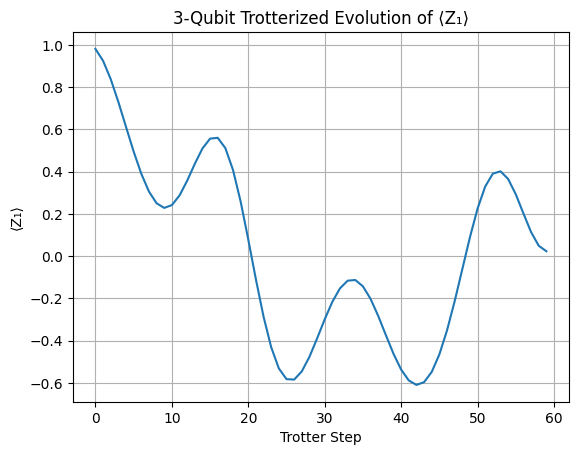

In [4]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Pauli
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------
# Purpose:
# Simulate 3-qubit transverse-field Ising model:
# H = J (Z0 Z1 + Z1 Z2) + h (X0 + X1 + X2)
# using second-order Trotter decomposition.
# ----------------------------------------

# Parameters
J = 1.0         # ZZ interaction strength
h = 1.0         # Transverse field strength
delta_t = 0.1   # Time step for Trotter evolution
steps = 60      # Number of Trotter steps

# Observable: ⟨Z₁⟩ (middle qubit)
Z1 = Pauli("IZI")

# Function to apply a second-order Trotter step
def second_order_trotter_step(qc, J, h, delta_t):
    # Half-step transverse field (RX) on all qubits
    for q in range(3):
        qc.rx(-h * delta_t, q)
    
    # ZZ interaction: Z0Z1
    qc.cx(0, 1)
    qc.rz(-2 * J * delta_t, 1)
    qc.cx(0, 1)

    # ZZ interaction: Z1Z2
    qc.cx(1, 2)
    qc.rz(-2 * J * delta_t, 2)
    qc.cx(1, 2)

    # Another half-step transverse field
    for q in range(3):
        qc.rx(-h * delta_t, q)

# Initial state: |+⟩ ⊗ |0⟩ ⊗ |+⟩
psi = Statevector.from_label('+0+')
z1_expectations = []

# Trotter evolution loop
for _ in range(steps):
    qc = QuantumCircuit(3)
    second_order_trotter_step(qc, J, h, delta_t)
    psi = psi.evolve(qc)

    # Expectation value ⟨Z₁⟩
    z_exp = psi.expectation_value(Z1).real
    z1_expectations.append(z_exp)

# Plotting
plt.plot(z1_expectations, label="⟨Z₁⟩")
plt.xlabel("Trotter Step")
plt.ylabel("⟨Z₁⟩")
plt.title("3-Qubit Trotterized Evolution of ⟨Z₁⟩")
plt.grid(True)
plt.show()


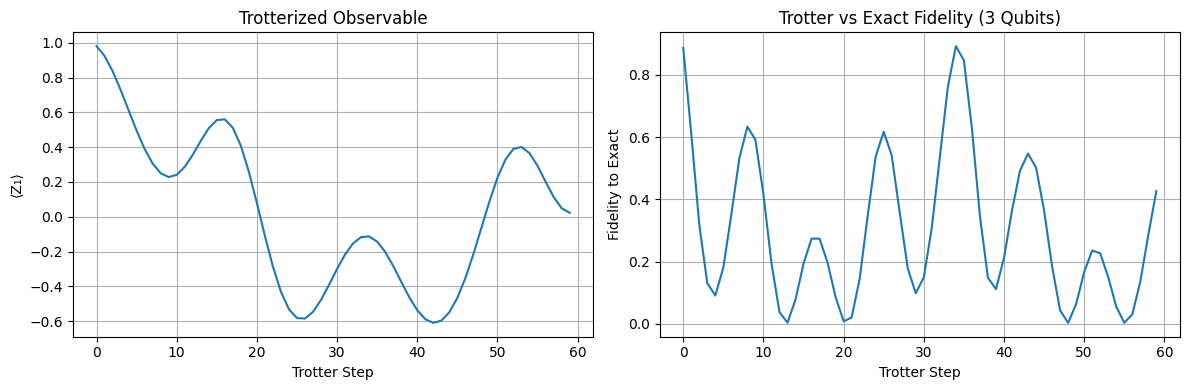

In [10]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Pauli, Operator
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

# -----------------------------
# Purpose:
# Compare Trotterized vs exact evolution for 3-qubit TFIM:
# H = J (Z0Z1 + Z1Z2) + h (X0 + X1 + X2)
# -----------------------------

# Parameters
J = 1.0
h = 1.0
delta_t = 0.1
steps = 60

# Pauli matrices
I = np.eye(2, dtype=complex)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)

# Kronecker product helper
def kron(*args):
    result = args[0]
    for a in args[1:]:
        result = np.kron(result, a)
    return result

# Build full Hamiltonian matrix
H = (
    J * (kron(Z, Z, I) + kron(I, Z, Z)) +
    h * (kron(X, I, I) + kron(I, X, I) + kron(I, I, X))
)
U_exact = expm(-1j * H * delta_t)  # Exact time evolution operator

# Observable: ⟨Z₁⟩
Z1 = Pauli("IZI")

# Trotter step (second-order)
def second_order_trotter_step(qc, J, h, delta_t):
    for q in range(3):
        qc.rx(-h * delta_t, q)

    # Z0Z1
    qc.cx(0, 1)
    qc.rz(-2 * J * delta_t, 1)
    qc.cx(0, 1)

    # Z1Z2
    qc.cx(1, 2)
    qc.rz(-2 * J * delta_t, 2)
    qc.cx(1, 2)

    for q in range(3):
        qc.rx(-h * delta_t, q)

# Initial state: |+0+⟩
psi0 = Statevector.from_label('+0+')
psi_exact = psi0.data.copy()
psi_trotter = psi0.copy()

fidelities = []
z1_expectations = []

# Time evolution loop
for _ in range(steps):
    # --- Exact evolution ---
    psi_exact = U_exact @ psi_exact  # vector update

    # --- Trotter evolution ---
    qc = QuantumCircuit(3)
    second_order_trotter_step(qc, J, h, delta_t)
    psi_trotter = psi_trotter.evolve(qc)

    # Fidelity
    F = np.abs(np.vdot(psi_exact, psi_trotter.data))**2
    fidelities.append(F)

    # ⟨Z₁⟩ from Trotter state
    z1_exp = psi_trotter.expectation_value(Z1).real
    z1_expectations.append(z1_exp)

# -----------------------------
# Plotting
# -----------------------------
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(z1_expectations, label='⟨Z₁⟩ (Trotter)')
plt.xlabel("Trotter Step")
plt.ylabel("⟨Z₁⟩")
plt.title("Trotterized Observable")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(fidelities, label='Fidelity')
plt.xlabel("Trotter Step")
plt.ylabel("Fidelity to Exact")
plt.title("Trotter vs Exact Fidelity (3 Qubits)")
plt.grid(True)

plt.tight_layout()
plt.show()
